<div align="center">
  <img src="http://gi-mosm.dem.isel.pt/compdrill/img/logo_isel.png"/>
</div>

<h1 align="center"> Instituto Superior de Engenharia de Lisboa </h1>
<h2 align="center"> Licenciatura em Engenharia Informática e Multimédia </h2>
<h3 align="center"> Semestre de Inverno 2020/2021 </h3>

<br></br>
<h3 align="center"> Projeto Final </h3>
<br></br>
<h2 align="center"> Aprendizagem Automática </h2>
<h4 align="center"> Docente: Prof. Gonçalo Marques </h4>
<br></br>
<br></br>

<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 30%;
  
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

</style>

<table align="center">
  <tr>
    <th>Nome</th>
    <th>Número</th>
    <th>Turma</th>
  <tr>
    <td>Maria Franco</td>
    <td>46320</td>
    <td>51D</td>
  </tr>
  <tr>
    <td>José Siopa</td>
    <td>46338</td>
    <td>51D</td>
  </tr>
</table>

<br></br>
<br></br>

<a name='indice'></a>
# Índice

[](#indice)
- [1. Introdução](#introducao)

- [2. Construção do vocabulário](#construcao)
    - [2.1 Carregamento dos dados e divisão em treino e teste](#carregamento)
  
    - [2.2 Limpeza dos dados de texto](#limpeza)
  
    - [2.3 Teste da função tf-idf com diferentes parâmetros para min_df, token_pattern e regularização inversa](#testetfidf)

    - [2.4 Taxa de acertos tf-idf com parâmetros elevados de min_df na classificação binária para averiguar qual o vocabulário mínimo possível, continuando a ter os melhores resultados](#minvoc)
  
    - [2.5 Teste da função tf-idf com inclusão de n-gramas](#testengramas)

    - [2.6 Função text2vector(Docs)](#text2vector)
  
- [3. Metodologias de teste e métricas de desempenho](#metodologias)
  
- [4. Classificadores](#classificadores)
  
    - [4.1 Classificadores Binários](#classificadoresBin)
  
    - [4.2 Classificadores Multi-classe](#classificadoresMulti)
  
    - [4.3 Funções binClassify(X) e multiClassify(X)](#classify)

- [5. PCA](#pca)

- [6. Clustering](#clustering)
  
    - [6.1 Clustering KMeans](#clusteringkmeans)

    - [6.2 Clustering Hierárquico](#clusteringhierarquico)

- [7. Conclusão](#conclusao)

<a name="introducao"></a> 
# 1. Introdução

Neste trabalho laboratiorial, o objetivo foi aplicar os conhecimentos obtidos na disciplina de modo a conseguir classificar dados de texto. Mais especificamente, pretende-se trabalhar com textos de críticas de cinema da plataforma IMDb. Para uma dada crítica, pretende-se determinar se é positiva ou negativa (classificação binária), ou qual foi a pontuação da crítica. Estas críticas apenas têm pontuações de 1-4 e de 7-10, isto é, foram excluídas as críticas negativas.

<a name="construcao"></a> 
# 2. Construção do vocabulário

In [1]:
# imports
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import re

<a name="carregamento"></a> 
## 2.1 Carregamento dos dados e divisão em treino e teste
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

In [2]:
# carregamento dos dados do ficheiro pickle
D = pickle.load(open('imdbCriticas.p','rb'))

# documentos que contêm as críticas
X = D['data']
# classificação decimal das críticas
y = D['target']
# classificação binária das críticas
y_bool = (y > 5) * 1.

X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)

print(D.keys())
print('Tipo de dados:', type(X))
print('Tamanho:', len(X))
print('Numero de classes:', len(np.unique(y)))

dict_keys(['data', 'target', 'DESC'])
Tipo de dados: <class 'list'>
Tamanho: 40000
Numero de classes: 8


<a name="limpeza"></a> 
## 2.2 Limpeza dos dados de texto
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

In [3]:
# dados de treino
# limpeza dos textos
Docs1 = [doc.replace('<br />', ' ') for doc in X1]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs1 = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs1]

# dados de teste
# limpeza dos textos
Docs2 = [doc.replace('<br />', ' ') for doc in X2]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs2 = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs2]

<a name="testetfidf"></a> 
## 2.3 Teste da função tf-idf com diferentes parâmetros para min_df, token_pattern e regularização inversa
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

### Taxa de acertos tf-idf com parâmetros: `min_df=[3 a 12]` e `token_pattern=r'\b\w\w+\b'` para classificação binária

In [14]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)

for i in range(3, 12):
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w+\b').fit(Docs1)
    print("min_df=", i, "->", len(tfidf.get_feature_names()))
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dl.fit(X1, y1)
    print('Acertos Treino:', dl.score(X1, y1))
    print('Acertos Teste:', dl.score(X2, y2))

min_df= 3 -> 34883
Acertos Treino: 0.9303571428571429
Acertos Teste: 0.8945
min_df= 4 -> 29889
Acertos Treino: 0.92975
Acertos Teste: 0.894
min_df= 5 -> 26422
Acertos Treino: 0.9288928571428572
Acertos Teste: 0.8938333333333334
min_df= 6 -> 23868
Acertos Treino: 0.9285
Acertos Teste: 0.8939166666666667
min_df= 7 -> 21893
Acertos Treino: 0.9279642857142857
Acertos Teste: 0.89425
min_df= 8 -> 20363
Acertos Treino: 0.9274285714285714
Acertos Teste: 0.8940833333333333
min_df= 9 -> 19023
Acertos Treino: 0.9269285714285714
Acertos Teste: 0.8945
min_df= 10 -> 17853
Acertos Treino: 0.9265
Acertos Teste: 0.89475
min_df= 11 -> 16830
Acertos Treino: 0.9262142857142858
Acertos Teste: 0.8941666666666667


### Taxa de acertos tf-idf com parâmetros: `min_df=[3 a 12]` e `token_pattern=r'\b\w\w+\b'` para classificação multi-classe

In [22]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
for i in range(3, 12):
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w+\b').fit(Docs1)
    print("min_df=", i, "->", len(tfidf.get_feature_names()))
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2',multi_class='multinomial', max_iter=1000, C=1, tol=1e-3)
    dl.fit(X1, y1)
    print('Acertos Treino:', dl.score(X1, y1))
    print('Acertos Teste:', dl.score(X2, y2))

min_df= 3 -> 34883
Acertos Treino: 0.48710714285714285
Acertos Teste: 0.1975
min_df= 4 -> 29889
Acertos Treino: 0.48192857142857143
Acertos Teste: 0.19716666666666666
min_df= 5 -> 26422
Acertos Treino: 0.4770357142857143
Acertos Teste: 0.19683333333333333
min_df= 6 -> 23868
Acertos Treino: 0.4727857142857143
Acertos Teste: 0.19741666666666666
min_df= 7 -> 21893
Acertos Treino: 0.46910714285714283
Acertos Teste: 0.19691666666666666
min_df= 8 -> 20363
Acertos Treino: 0.46532142857142855
Acertos Teste: 0.19666666666666666
min_df= 9 -> 19023
Acertos Treino: 0.46189285714285716
Acertos Teste: 0.1975
min_df= 10 -> 17853
Acertos Treino: 0.45803571428571427
Acertos Teste: 0.19783333333333333
min_df= 11 -> 16830
Acertos Treino: 0.4544642857142857
Acertos Teste: 0.19783333333333333


### Taxa de acertos tf-idf com parâmetros: `min_df=[3 a 12]` e `token_pattern=r'\b\w\w\w+\b'` para classificação binária

In [15]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)

for i in range(3, 12):
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    print("min_df=", i, "->", len(tfidf.get_feature_names()))
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dl.fit(X1, y1)
    print('Acertos Treino:', dl.score(X1, y1))
    print('Acertos Teste:', dl.score(X2, y2))

min_df= 3 -> 34561
Acertos Treino: 0.9329642857142857
Acertos Teste: 0.8943333333333333
min_df= 4 -> 29601
Acertos Treino: 0.9321785714285714
Acertos Teste: 0.8945833333333333
min_df= 5 -> 26175
Acertos Treino: 0.9314285714285714
Acertos Teste: 0.89425
min_df= 6 -> 23641
Acertos Treino: 0.9306071428571429
Acertos Teste: 0.894
min_df= 7 -> 21684
Acertos Treino: 0.9303214285714285
Acertos Teste: 0.8935833333333333
min_df= 8 -> 20169
Acertos Treino: 0.9297142857142857
Acertos Teste: 0.8936666666666667
min_df= 9 -> 18842
Acertos Treino: 0.9291785714285714
Acertos Teste: 0.8936666666666667
min_df= 10 -> 17684
Acertos Treino: 0.9286428571428571
Acertos Teste: 0.8930833333333333
min_df= 11 -> 16668
Acertos Treino: 0.9282142857142858
Acertos Teste: 0.89325


### Taxa de acertos tf-idf com parâmetros: `min_df=[3 a 12]` e `token_pattern=r'\b\w\w\w+\b'` para classificação multi-classe

In [23]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
for i in range(3, 12):
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    print("min_df=", i, "->", len(tfidf.get_feature_names()))
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=1000, C=1, tol=1e-3)
    dl.fit(X1, y1)
    print('Acertos Treino:', dl.score(X1, y1))
    print('Acertos Teste:', dl.score(X2, y2))

min_df= 3 -> 34561
Acertos Treino: 0.49560714285714286
Acertos Teste: 0.19666666666666666
min_df= 4 -> 29601
Acertos Treino: 0.4900357142857143
Acertos Teste: 0.19683333333333333
min_df= 5 -> 26175
Acertos Treino: 0.486
Acertos Teste: 0.19566666666666666
min_df= 6 -> 23641
Acertos Treino: 0.48060714285714284
Acertos Teste: 0.19566666666666666
min_df= 7 -> 21684
Acertos Treino: 0.4767857142857143
Acertos Teste: 0.19566666666666666
min_df= 8 -> 20169
Acertos Treino: 0.472
Acertos Teste: 0.195
min_df= 9 -> 18842
Acertos Treino: 0.46810714285714283
Acertos Teste: 0.19558333333333333
min_df= 10 -> 17684
Acertos Treino: 0.46439285714285716
Acertos Teste: 0.196
min_df= 11 -> 16668
Acertos Treino: 0.4612142857142857
Acertos Teste: 0.19583333333333333


### Taxa de acertos tf-idf com parâmetros: `min_df=[3 a 12]` e `token_pattern=r'\b\w\w\w\w+\b'` para classificação binária

In [13]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)
for i in range(3, 12):
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w\w\w+\b').fit(Docs1)
    print("min_df=", i, "->", len(tfidf.get_feature_names()))
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dl.fit(X1, y1)
    print('Acertos Treino:', dl.score(X1, y1))
    print('Acertos Teste:', dl.score(X2, y2))

min_df= 3 -> 33452
Acertos Treino: 0.9326071428571429
Acertos Teste: 0.8900833333333333
min_df= 4 -> 28629
Acertos Treino: 0.9319285714285714
Acertos Teste: 0.8899166666666667
min_df= 5 -> 25289
Acertos Treino: 0.9312142857142857
Acertos Teste: 0.8896666666666667
min_df= 6 -> 22828
Acertos Treino: 0.9307857142857143
Acertos Teste: 0.8898333333333334
min_df= 7 -> 20941
Acertos Treino: 0.93
Acertos Teste: 0.8895833333333333
min_df= 8 -> 19466
Acertos Treino: 0.9293928571428571
Acertos Teste: 0.8898333333333334
min_df= 9 -> 18175
Acertos Treino: 0.929
Acertos Teste: 0.8904166666666666
min_df= 10 -> 17044
Acertos Treino: 0.9282142857142858
Acertos Teste: 0.89
min_df= 11 -> 16055
Acertos Treino: 0.9278571428571428
Acertos Teste: 0.8905833333333333


### Taxa de acertos tf-idf com parâmetros: `min_df=[3 a 12]` e `token_pattern=r'\b\w\w\w\w+\b'` para classificação multi-classe

In [28]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
for i in range(3, 12):
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w\w\w+\b').fit(Docs1)
    print("min_df=", i, "->", len(tfidf.get_feature_names()))
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2', max_iter=1000, C=1, multi_class='multinomial', tol=1e-3)
    dl.fit(X1, y1)
    print('Acertos Treino:', dl.score(X1, y1))
    print('Acertos Teste:', dl.score(X2, y2))

min_df= 3 -> 33452
Acertos Treino: 0.5166785714285714
Acertos Teste: 0.19483333333333333
min_df= 4 -> 28629
Acertos Treino: 0.5110357142857143
Acertos Teste: 0.19441666666666665
min_df= 5 -> 25289
Acertos Treino: 0.5054642857142857
Acertos Teste: 0.19516666666666665
min_df= 6 -> 22828
Acertos Treino: 0.49992857142857144
Acertos Teste: 0.19491666666666665
min_df= 7 -> 20941
Acertos Treino: 0.4949642857142857
Acertos Teste: 0.19441666666666665
min_df= 8 -> 19466
Acertos Treino: 0.4908214285714286
Acertos Teste: 0.19508333333333333
min_df= 9 -> 18175
Acertos Treino: 0.4861785714285714
Acertos Teste: 0.19466666666666665
min_df= 10 -> 17044
Acertos Treino: 0.481
Acertos Teste: 0.19458333333333333
min_df= 11 -> 16055
Acertos Treino: 0.47782142857142856
Acertos Teste: 0.1945


### Visualização dos resultados do tf-idf em gráficos e seus efeitos na dimensão do vocabulário

In [57]:
def plot_taxa_acertos(arrBiTreino, arrBiTeste, arrMultiTreino, arrMultiTeste, n_tokens):
    arrBiTreino = np.round(arrBiTreino, 4); arrBiTeste = np.round(arrBiTeste, 4)
    arrMultiTreino = np.round(arrMultiTreino, 4); arrMultiTeste = np.round(arrMultiTeste, 4)

    f, (ax, ax2) = plt.subplots(2, 1)
    f.suptitle('Taxa de acerto com tokens de {} ou mais letras em função do min_df'.format(n_tokens))
    f.set_figwidth(10); f.set_figheight(7)
    min_df_vals = [r for r in range(3, 12)]
    ax.plot(min_df_vals, arrBiTreino, '.-', label='Treino Binário')
    ax.plot(min_df_vals, arrBiTeste, '.-', label='Teste Binário')
    ax2.plot(min_df_vals, arrMultiTreino, '.r-', label='Treino Multi-classe')
    ax2.plot(min_df_vals, arrMultiTeste, '.g-', label='Teste Multi-classe')

    ax.set_ylim(.88, 0.94)
    ax2.set_ylim(.17, .55)

    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()

    d = .015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(); ax2.grid()

    for i_x, i_y in zip(min_df_vals, arrBiTreino):
        ax.text(i_x - 0.3, i_y + 0.003, '({})'.format(i_y))
    for i_x, i_y in zip(min_df_vals, arrBiTeste):
        ax.text(i_x - 0.3, i_y + 0.003, '({})'.format(i_y))

    for i_x, i_y in zip(min_df_vals, arrMultiTreino):
        ax2.text(i_x - 0.3, i_y + 0.015, '({})'.format(i_y))
    for i_x, i_y in zip(min_df_vals, arrMultiTeste):
        ax2.text(i_x - 0.3, i_y + 0.015, '({})'.format(i_y))

    f.text(0.01, 0.5, 'Taxa de Acertos', ha='center', va='center', rotation='vertical')
    plt.xlabel('min_df'); plt.ylabel(' '); plt.show()

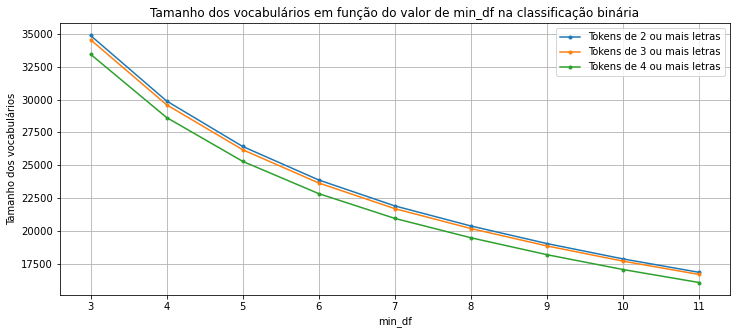

In [64]:
acertos_voc2_treino_bi = [0.9303571428571429, 0.92975, 0.9288928571428572, 0.9285, 0.9279642857142857, 0.9274285714285714, 0.9269285714285714, 0.9265, 0.9262142857142858]
acertos_voc2_teste_bi = [0.8945, 0.894, 0.8938333333333334, 0.8939166666666667, 0.89425, 0.8940833333333333, 0.8945, 0.89475, 0.8941666666666667]
acertos_voc2_treino_multi = [0.48710714285714285, 0.48192857142857143, 0.4770357142857143, 0.4727857142857143, 0.46910714285714283, 0.46532142857142855, 0.46189285714285716, 0.45803571428571427, 0.4544642857142857]
acertos_voc2_teste_multi = [0.1975, 0.19716666666666666, 0.19683333333333333, 0.19741666666666666, 0.19691666666666666, 0.19666666666666666, 0.1975, 0.19783333333333333, 0.19783333333333333]
plot_taxa_acertos(acertos_voc2_treino_bi, acertos_voc2_teste_bi, acertos_voc2_treino_multi, acertos_voc2_teste_multi, 2)

acertos_voc3_treino_bi = [0.9329642857142857, 0.9321785714285714, 0.9314285714285714, 0.9306071428571429, 0.9303214285714285, 0.9297142857142857, 0.9291785714285714, 0.9286428571428571, 0.9282142857142858]
acertos_voc3_teste_bi = [0.8943333333333333, 0.8945833333333333, 0.89425, 0.894, 0.8935833333333333, 0.8936666666666667, 0.8936666666666667, 0.8930833333333333, 0.89325]
acertos_voc3_treino_multi = [0.49560714285714286, 0.4900357142857143, 0.486, 0.48060714285714284, 0.4767857142857143, 0.472, 0.46810714285714283, 0.46439285714285716, 0.4612142857142857]
acertos_voc3_teste_multi = [0.19666666666666666, 0.19683333333333333, 0.19566666666666666, 0.19566666666666666, 0.19566666666666666, 0.195, 0.19558333333333333, 0.196, 0.19583333333333333]
plot_taxa_acertos(acertos_voc3_treino_bi, acertos_voc3_teste_bi, acertos_voc3_treino_multi, acertos_voc3_teste_multi, 3)

acertos_voc4_treino_bi = [0.9326071428571429, 0.9319285714285714, 0.9312142857142857, 0.9307857142857143, 0.93, 0.9293928571428571, 0.929, 0.9282142857142858, 0.9278571428571428]
acertos_voc4_teste_bi = [0.8900833333333333, 0.8899166666666667, 0.8896666666666667, 0.8898333333333334, 0.8895833333333333, 0.8898333333333334, 0.8904166666666666, 0.89, 0.8905833333333333]
acertos_voc4_treino_multi = [0.5166785714285714, 0.5110357142857143, 0.5054642857142857, 0.49992857142857144, 0.4949642857142857, 0.4908214285714286, 0.4861785714285714, 0.481, 0.47782142857142856]
acertos_voc4_teste_multi = [0.19483333333333333, 0.19441666666666665, 0.19516666666666665, 0.19491666666666665, 0.19441666666666665, 0.19508333333333333, 0.19466666666666665, 0.19458333333333333, 0.1945]
plot_taxa_acertos(acertos_voc4_treino_bi, acertos_voc4_teste_bi, acertos_voc4_treino_multi, acertos_voc4_teste_multi, 4)

voc_size2 = [34883, 29889, 26422, 23868, 21893, 20363, 19023, 17853, 16830]
voc_size3 = [34561, 29601, 26175, 23641, 21684, 20169, 18842, 17684, 16668]
voc_size4 = [33452, 28629, 25289, 22828, 20941, 19466, 18175, 17044, 16055]
min_df_vals = [r for r in range(3, 12)]
plt.figure(figsize=(12,5))
plt.plot(min_df_vals, voc_size2, '.-')
plt.plot(min_df_vals, voc_size3, '.-')
plt.plot(min_df_vals, voc_size4, '.-')
plt.title("Tamanho dos vocabulários em função do valor de min_df na classificação binária")
plt.legend(['Tokens de 2 ou mais letras', 'Tokens de 3 ou mais letras', 'Tokens de 4 ou mais letras'])
plt.xlabel('min_df'); plt.ylabel('Tamanho dos vocabulários'); plt.grid(); plt.show()

Observa-se que não compensa a otimização da taxa de acertos na classificação multi-classe, devido a esta ser muito baixa. Logo escolhemos usar os melhores parâmetros para o tf-idf na classificação binária.

Assim, observamos que o melhor valor para min_df é 4 e para token_pattern é 3 ou mais letras, porque são os valores que apresentam melhores taxas de acerto com um tamanho de vocabulário mais reduzido que o tamanho original.

<a name="minvoc"></a> 
## 2.4 Taxa de acertos tf-idf com parâmetros elevados de `min_df` e `token_pattern=r'\b\w\w\w+\b'` na classificação binária para averiguar qual o vocabulário mínimo possível, continuando a ter os melhores resultados
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

min_df:  15
Acertos Treino: 0.9271071428571429
Acertos Teste: 0.89325
Tamanho do vocabulário: 13842
min_df:  20
Acertos Treino: 0.9249285714285714
Acertos Teste: 0.8939166666666667
Tamanho do vocabulário: 11450
min_df:  30
Acertos Treino: 0.9224285714285714
Acertos Teste: 0.893
Tamanho do vocabulário: 8750
min_df:  50
Acertos Treino: 0.918
Acertos Teste: 0.8916666666666667
Tamanho do vocabulário: 6113
min_df:  100
Acertos Treino: 0.9103571428571429
Acertos Teste: 0.8888333333333334
Tamanho do vocabulário: 3669
min_df:  200
Acertos Treino: 0.89975
Acertos Teste: 0.8815
Tamanho do vocabulário: 2104


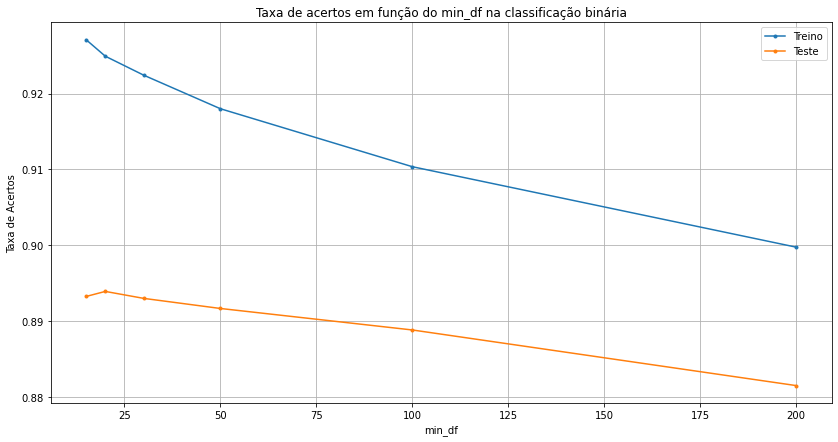

In [46]:
min_df = [15, 20, 30, 50, 100, 200]
treino = []
teste = []
tamanhos = []

for i in min_df:
    X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)
    tfidf = TfidfVectorizer(min_df=i, token_pattern=r'\b\w\w\w+\b').fit(Docs1)
    X1 = tfidf.transform(Docs1)
    X2 = tfidf.transform(Docs2)
    dl = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dl.fit(X1, y1)
    treino_score = dl.score(X1, y1)
    teste_score = dl.score(X2, y2)
    treino.append(treino_score)
    teste.append(teste_score)
    tamanhos.append(len(tfidf.get_feature_names()))

    print('min_df: ', i)
    print('Acertos Treino:', treino_score)
    print('Acertos Teste:', teste_score)
    print('Tamanho do vocabulário:', len(tfidf.get_feature_names()))

plt.figure(figsize=(14, 7))
plt.xlabel('min_df')
plt.ylabel('Tamanho dos vocabulários')
plt.title('Tamanho dos vocabulários em função do valor de min_df na classificação binária')
plt.plot(min_df, tamanhos, '.-', label='Tokens de 3 ou mais letras')
plt.legend()
plt.grid(); plt.show()

plt.figure(figsize=(14, 7))
plt.xlabel('min_df')
plt.ylabel('Taxa de Acertos')
plt.title('Taxa de acertos em função do min_df na classificação binária')
plt.plot(min_df, treino, '.-', label='Treino')
plt.plot(min_df, teste, '.-', label='Teste')
plt.legend()
plt.grid(); plt.show()

<a name="testengramas"></a> 
## 2.5 Teste da função tf-idf com inclusão de n-gramas
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

In [47]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)

### n-gramas
for i in range(1,4):
    print(i)
    tfidfn = TfidfVectorizer(min_df=4, ngram_range=(i,i), token_pattern=r'\b\w\w\w+\b').fit(Docs1)

    X1n = tfidfn.transform(Docs1)
    X2n = tfidfn.transform(Docs2)

    dln = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dln.fit(X1n, y1)
    print('Acertos Treino:', dln.score(X1n, y1))
    print('Acertos Teste:', dln.score(X2n, y2))
    print(len(tfidfn.get_feature_names()))

1
Acertos Treino: 0.9321785714285714
Acertos Teste: 0.8945833333333333
29601
2
Acertos Treino: 0.9626071428571429
Acertos Teste: 0.8841666666666667
141839
3
Acertos Treino: 0.9621071428571428
Acertos Teste: 0.82475
81743


In [34]:
### n-gramas
for i in range(1,4):
    print(i)
    tfidfn = TfidfVectorizer(min_df=4, ngram_range=(1,i), token_pattern=r'\b\w\w\w\w+\b').fit(Docs1)
    #com 3ou+letras e quadri-gramas:
    #tfidfn = pickle.load(open('bowtfidf.p', 'rb'))

    X1n = tfidfn.transform(Docs1)
    X2n = tfidfn.transform(Docs2)

    dln = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dln.fit(X1n, y1)
    print('Acertos Treino:', dln.score(X1n, y1))
    print('Acertos Teste:', dln.score(X2n, y2))
    print(len(tfidfn.get_feature_names()))

1
Acertos Treino: 0.9319285714285714
Acertos Teste: 0.8899166666666667
28629
2
Acertos Treino: 0.9490357142857143
Acertos Teste: 0.8940833333333333
135047
3
Acertos Treino: 0.9508928571428571
Acertos Teste: 0.89475
160627


In [33]:
### n-gramas
for i in range(1,4):
    print(i)
    tfidfn = TfidfVectorizer(min_df=30, ngram_range=(1,i), token_pattern=r'\b\w\w\w\w+\b').fit(Docs1)
    #com 3ou+letras e quadri-gramas:
    #tfidfn = pickle.load(open('bowtfidf.p', 'rb'))

    X1n = tfidfn.transform(Docs1)
    X2n = tfidfn.transform(Docs2)

    dln = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
    dln.fit(X1n, y1)
    print('Acertos Treino:', dln.score(X1n, y1))
    print('Acertos Teste:', dln.score(X2n, y2))
    print(len(tfidfn.get_feature_names()))

1
Acertos Treino: 0.9213928571428571
Acertos Teste: 0.88825
8361
2
Acertos Treino: 0.9330714285714286
Acertos Teste: 0.8926666666666667
16070
3
Acertos Treino: 0.9336428571428571
Acertos Teste: 0.8933333333333333
16898
4


In [48]:
#com 3ou+letras e quadri-gramas:
tfidfn = pickle.load(open('bowtfidf.p', 'rb'))

X1n = tfidfn.transform(Docs1)
X2n = tfidfn.transform(Docs2)

dln = LogisticRegression(penalty='l2', max_iter=1000, C=1, tol=1e-3)
dln.fit(X1n, y1)
print('Acertos Treino:', dln.score(X1n, y1))
print('Acertos Teste:', dln.score(X2n, y2))
print(len(tfidfn.get_feature_names()))

Acertos Treino: 0.9546428571428571
Acertos Teste: 0.9001666666666667
271971


<a name="text2vector"></a> 
## 2.6 Função <code>text2vector(Docs)</code>
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

In [8]:
def text2vector(Docs):
    # limpeza dos textos
    Docs = [doc.replace('<br />', ' ') for doc in Docs]
    # de a-z, A-Z e caracteres especiais latinos unicode
    Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]
    tfidf = pickle.load(open('noStemmer.p', 'rb'))
    return tfidf.transform(Docs)

<a name="metodologias"></a> 
# 3. Metodologias de teste e métricas de desempenho
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

Para testarmos os modelos treinados, escolhemos uma metodologia de teste que consistiu em dividir os dados baralhados em treino e em teste, sendo 70% dos dados para treino, e 30% para teste. A mesma função, _train_test_split_, permite estratificar os dados, isto é, a divisão feita terá a mesma proporção dos valores de cada classe no _array_ passado como parâmetro. Depois, o classificador utilizado foi o mesmo para todos os modelos, com os mesmos parâmetros. 

Diferença entre quantidade de críticas negativas e positivas: 420


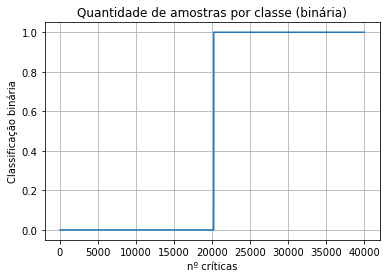

In [45]:
plt.title("Quantidade de amostras por classe (binária)")
plt.xlabel('nº críticas'); plt.ylabel('Classificação binária'); plt.grid();
plt.plot(y_bool[np.argsort(y_bool)])
print("Diferença entre quantidade de críticas negativas e positivas:", np.abs(np.sum(y_bool==0) - np.sum(y_bool==1)))

A diferença entre a quantidade de críticas positivas e negativas é pequena, o que mostra uma distribuição balanceada de amostras. Assim, pode-se avaliar o desempenho da classificação binária através da quantidade de observações bem classificadas (_mean accuracy_). Esta taxa de acerto é igual ao inverso da probabilidade total de erro, e pode ser dada pela seguinte expressão matemática:
$$
ACC=\frac{tp+tn}{tp+fp+tn+fn}
$$

Nos classificadores utilizados, esta métrica é dada pela função _score_.
Consideramos que é a métrica mais apropriada, visto que se pretende obter o mínimo de críticas mal classificadas possível, e não é um problema em que se considere mais grave a presença de falsos positivos ou de falsos negativos, que implicasse o uso de outras métricas.


Querendo eliminar completamente a diferença, pode-se calcular a exatidão balanceada (_balanced_accuracy_) que, no caso binário, consiste em fazer a média aritmética da sensitividade (_sensitivity_ = _true positive rate_) e da especificidade (_specitivity_ = _true negative rate_). Ainda assim, não notámos diferença suficiente nos resultados para utilizarmos esta métrica.
$$
Balanced ACC=\frac{1}{2}(\frac{tp}{tp+fn}+\frac{tn}{tn+fp})
$$

No final, teremos um gráfico com a comparação dos melhores valores de _accuracy_ para cada classificador.

<a name="classificadores"></a> 
# 4. Classificadores
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

<a name="classificadoresBin"></a> 
## 4.1 Classificadores Binários
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

### Classificador Discriminante Logistico

#### Taxa de acertos LogisticRegressionCV para diferentes valores de regularização inversa (C) e regularização Ridge

In [11]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

i = [0.1, 0.5, 1, 1.5, 2.5, 3, 3.5, 10]
dl = LogisticRegressionCV(penalty='l2', max_iter=1000, solver='saga', Cs=i, tol=1e-3, random_state=0)
dl.fit(X1, y1)

from sklearn.metrics import accuracy_score, balanced_accuracy_score

print('% de acertos no treino:', dl.score(X1, y1))
print('% de acertos no teste: ', dl.score(X2, y2))
print('% de acertos no teste com função accuracy_score: ', accuracy_score(y2, dl.predict(X2)))
print('% de acertos no teste com função balanced_accuracy_score: ', balanced_accuracy_score(y2, dl.predict(X2)))
print('Melhor valor de C', dl.C_)

% de acertos no treino: 0.9583571428571429
% de acertos no teste:  0.8990833333333333
% de acertos no teste com função accuracy_score:  0.8990833333333333
% de acertos no teste com função balanced_accuracy_score:  0.8991395884729625
Melhor valor de C [3.]


#### Taxa de acertos LogisticRegression com o melhor valor de regularização inversa (C) obtido para a regularização Ridge, mas agora para a regularização Lasso, e com validação cruzada

In [50]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
dl = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, C=3, tol=1e-3, random_state=0)
dl.fit(X1, y1)

ye1 = cross_val_predict(dl, X1, y1, cv=cv)
acertos1 = cross_val_score(dl, X1, y1, cv=cv)
ye2 = cross_val_predict(dl, X2, y2, cv=cv)
acertos2 = cross_val_score(dl, X2, y2, cv=cv)
print('% de acertos no treino:', np.mean(acertos1))
print('% de acertos no teste: ', np.mean(acertos2))

% de acertos no treino: 0.8865714285714287
% de acertos no teste:  0.8705833333333333


Conclui-se que o melhor valor para o parâmetro C é 3, e que se obtêm melhores resultados utilizando a regularização Ridge.

### Classificador KNN (K-vizinhos mais próximos)

In [11]:
X1, X2, y1, y2 = train_test_split(X[:10000], y_bool[:10000], test_size=0.3, stratify=y_bool[:10000], random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

for neighbor in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X1, y1)

    print('Neighbors:', neighbor)
    print('% de acertos no treino:', knn.score(X1, y1))
    print('% de acertos no teste: ', knn.score(X2, y2))

Neighbors: 1
% de acertos no treino: 1.0
% de acertos no teste:  0.7203333333333334
Neighbors: 2
% de acertos no treino: 0.8824285714285715
% de acertos no teste:  0.7113333333333334
Neighbors: 3
% de acertos no treino: 0.8712857142857143
% de acertos no teste:  0.7376666666666667
Neighbors: 4
% de acertos no treino: 0.8491428571428571
% de acertos no teste:  0.7353333333333333
Neighbors: 5
% de acertos no treino: 0.8441428571428572
% de acertos no teste:  0.743
Neighbors: 6
% de acertos no treino: 0.8301428571428572
% de acertos no teste:  0.7456666666666667
Neighbors: 7
% de acertos no treino: 0.8288571428571428
% de acertos no teste:  0.753
Neighbors: 8
% de acertos no treino: 0.824
% de acertos no teste:  0.7563333333333333
Neighbors: 9
% de acertos no treino: 0.8237142857142857
% de acertos no teste:  0.7603333333333333
Neighbors: 10
% de acertos no treino: 0.8222857142857143
% de acertos no teste:  0.7616666666666667
Neighbors: 20
% de acertos no treino: 0.814
% de acertos no tes

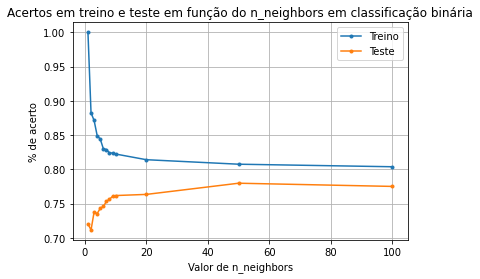

In [46]:
neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
acertos_2_treino = [1, 0.8824285714285715, 0.8712857142857143, 0.8491428571428571, 0.8441428571428572, 0.8301428571428572, 0.8288571428571428, 0.824, 0.8237142857142857, 0.8222857142857143, 0.814, 0.8074285714285714, 0.8037142857142857]
acertos_2_teste = [0.720333333333334, 0.7113333333333334, 0.7376666666666667, 0.7353333333333333, 0.743, 0.7456666666666667, 0.753, 0.7563333333333333, 0.7603333333333333, 0.7616666666666667, 0.7633333333333333, 0.7796666666666666, 0.775]
plt.plot(neighbors, acertos_2_treino, '.-', label='Treino')
plt.plot(neighbors, acertos_2_teste, '.-', label='Teste')
plt.title("Acertos em treino e teste em função do n_neighbors em classificação binária")
plt.xlabel('Valor de n_neighbors'); plt.ylabel('% de acerto'); plt.grid();
plt.legend()
plt.show()

O KNN tende a sobreaprender, com um número de vizinhos mais baixo. À medida que se o aumenta, verifica-se que a taxa de acertos em treino diminui, e a taxa de acertos em teste aumenta. Consideramos que um valor correto para o parâmetro número de vizinhos seja em torno de 50.

### Classificador Linear SVC

In [14]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

for i in [0.1, 0.2, 0.3, 0.5, 1, 3]:  
    svc = LinearSVC(C=i, tol=1e-3).fit(X1, y1)

    print('C =', i)
    print('% de acertos no treino:', svc.score(X1, y1))
    print('% de acertos no teste: ', svc.score(X2, y2), '\n')

C = 0.1
% de acertos no treino: 0.9344285714285714
% de acertos no teste:  0.89675 

C = 0.2
% de acertos no treino: 0.9525714285714286
% de acertos no teste:  0.89925 

C = 0.3
% de acertos no treino: 0.961
% de acertos no teste:  0.89875 

C = 0.5
% de acertos no treino: 0.9725
% de acertos no teste:  0.8986666666666666 

C = 1
% de acertos no treino: 0.9856428571428572
% de acertos no teste:  0.8950833333333333 

C = 3
% de acertos no treino: 0.9977142857142857
% de acertos no teste:  0.8856666666666667 



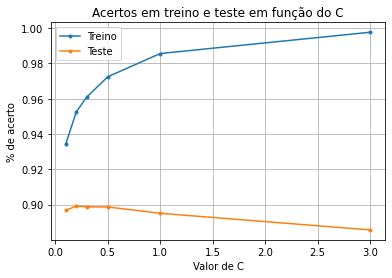

In [47]:
C = [0.1, 0.2, 0.3, 0.5, 1, 3]
acertos_2_treino = [0.9344285714285714, 0.9525714285714286, 0.961, 0.9725, 0.9856428571428572, 0.9977142857142857]
acertos_2_teste = [0.89675, 0.89925, 0.89875, 0.8986666666666666, 0.8950833333333333, 0.8856666666666667]
plt.plot(C, acertos_2_treino, '.-', label='Treino')
plt.plot(C, acertos_2_teste, '.-', label='Teste')
plt.title("Acertos em treino e teste em função do C")
plt.xlabel('Valor de C'); plt.ylabel('% de acerto'); plt.grid();
plt.legend()
plt.show()

In [15]:
svc = LinearSVC(C=0.201).fit(X1, y1)

print('% de acertos no treino:', svc.score(X1, y1))
print('% de acertos no teste: ', svc.score(X2, y2), '\n')

% de acertos no treino: 0.9527857142857142
% de acertos no teste:  0.8994166666666666 




<a name="classificadoresMulti"></a> 
## 4.2 Classificadores Multi-classe
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

### Classificador Discriminante Logistico

In [37]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

dl = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', C=3, tol=1e-3)
dl.fit(X1, y1)

print('% de acertos no treino:', dl.score(X1, y1))
print('% de acertos no teste: ', dl.score(X2, y2))

% de acertos no treino: 0.8516071428571429
% de acertos no teste:  0.43133333333333335


Com C = 3, já se verifica sobreaprendizagem, pela elevada diferença entre o resultado em treino e em teste.

In [111]:
i = [0.1, 0.5, 1, 1.5, 2.5, 3, 3.5, 10]
dl = LogisticRegressionCV(penalty='l2', max_iter=1000, solver='saga', multi_class='multinomial', Cs=i, tol=1e-3, random_state=0)
dl.fit(X1, y1)
print('Acertos Treino:', dl.score(X1, y1))
print('Acertos Teste:', dl.score(X2, y2))
print('Best C', dl.C_)

Acertos Treino: 0.6945357142857143
Acertos Teste: 0.44358333333333333
Best C [1. 1. 1. 1. 1. 1. 1. 1.]


In [39]:
dl = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', C=1.03, tol=1e-3)
dl.fit(X1, y1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

print('% de acertos no treino:', dl.score(X1, y1))
print('% de acertos no teste: ', dl.score(X2, y2))

print('% de acertos no treino xval:', np.mean(cross_val_score(dl, X1, y1, cv=cv)))
print('% de acertos no teste xval: ', np.mean(cross_val_score(dl, X2, y2, cv=cv)))

% de acertos no treino: 0.6984642857142858
% de acertos no teste:  0.4445
% de acertos no treino xval: 0.43603571428571436
% de acertos no teste xval:  0.42375000000000007


### Classificador KNN (K-vizinhos mais próximos)

In [17]:
X1, X2, y1, y2 = train_test_split(X[:10000], y[:10000], test_size=0.3, stratify=y[:10000], random_state=0) #10000 só p ver se morre
X1 = text2vector(X1)
X2 = text2vector(X2)

for neighbor in [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 1000]:
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(X1, y1)

    print('Neighbors:', neighbor)
    print('% de acertos no treino:', knn.score(X1, y1))
    print('% de acertos no teste: ', knn.score(X2, y2))

Neighbors: 2
% de acertos no treino: 0.642
% de acertos no teste:  0.25466666666666665
Neighbors: 3
% de acertos no treino: 0.5468571428571428
% de acertos no teste:  0.2673333333333333
Neighbors: 4
% de acertos no treino: 0.5164285714285715
% de acertos no teste:  0.2813333333333333
Neighbors: 5
% de acertos no treino: 0.505
% de acertos no teste:  0.2856666666666667
Neighbors: 6
% de acertos no treino: 0.48142857142857143
% de acertos no teste:  0.294
Neighbors: 7
% de acertos no treino: 0.4612857142857143
% de acertos no teste:  0.29933333333333334
Neighbors: 8
% de acertos no treino: 0.4441428571428571
% de acertos no teste:  0.30966666666666665
Neighbors: 9
% de acertos no treino: 0.43557142857142855
% de acertos no teste:  0.314
Neighbors: 10
% de acertos no treino: 0.43242857142857144
% de acertos no teste:  0.31966666666666665
Neighbors: 20
% de acertos no treino: 0.39371428571428574
% de acertos no teste:  0.32233333333333336
Neighbors: 50
% de acertos no treino: 0.36885714285

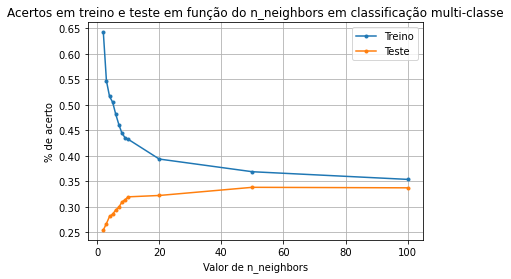

In [48]:
neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100]
acertos_2_treino = [0.642, 0.5468571428571428, 0.5164285714285715, 0.505, 0.48142857142857143, 0.4612857142857143, 0.4441428571428571, 0.43557142857142855, 0.43242857142857144, 0.39371428571428574, 0.3688571428571429, 0.35385714285714287]
acertos_2_teste = [0.25466666666666665, 0.2673333333333333, 0.2813333333333333, 0.2856666666666667, 0.294, 0.29933333333333334, 0.30966666666666665, 0.314, 0.31966666666666665, 0.32233333333333336, 0.3383333333333333, 0.3373333333333333]
plt.plot(neighbors, acertos_2_treino, '.-', label='Treino')
plt.plot(neighbors, acertos_2_teste, '.-', label='Teste')
plt.title("Acertos em treino e teste em função do n_neighbors em classificação multi-classe")
plt.xlabel('Valor de n_neighbors'); plt.ylabel('% de acerto'); plt.grid();
plt.legend()
plt.show()

Através da análise dos resultados para o classificador multi-classe KNN, considera-se que o melhor valor para o parâmetro número de vizinhos em torno de 50.

### Classificador Linear SVC

In [14]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

for i in [0.01, 0.05, 0.1, 0.2, 1]:  
    svc = LinearSVC(C=i, tol=1e-3).fit(X1, y1)

    print('C =', i)
    print('% de acertos no treino:', svc.score(X1, y1))
    print('% de acertos no teste: ', svc.score(X2, y2), '\n')

C = 0.01
% de acertos no treino: 0.43610714285714286
% de acertos no teste:  0.39958333333333335 

C = 0.05
% de acertos no treino: 0.5824285714285714
% de acertos no teste:  0.4375 

C = 0.1
% de acertos no treino: 0.6733571428571429
% de acertos no teste:  0.4425 

C = 0.2
% de acertos no treino: 0.7717142857142857
% de acertos no teste:  0.44083333333333335 

C = 1
% de acertos no treino: 0.9495
% de acertos no teste:  0.40458333333333335 



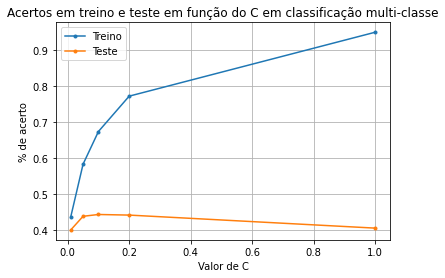

In [49]:
C = [0.01, 0.05, 0.1, 0.2, 1]
acertos_2_treino = [0.43610714285714286, 0.5824285714285714, 0.6733571428571429, 0.7717142857142857, 0.9495]
acertos_2_teste = [0.39958333333333335, 0.4375, 0.4425, 0.44083333333333335, 0.40458333333333335 ]
plt.plot(C, acertos_2_treino, '.-', label='Treino')
plt.plot(C, acertos_2_teste, '.-', label='Teste')
plt.title("Acertos em treino e teste em função do C em classificação multi-classe")
plt.xlabel('Valor de C'); plt.ylabel('% de acerto'); plt.grid();
plt.legend()
plt.show()

In [16]:
svc = LinearSVC(C=0.149, tol=1e-3).fit(X1, y1)
print('% de acertos no treino:', svc.score(X1, y1))
print('% de acertos no teste: ', svc.score(X2, y2), '\n')

strat = StratifiedKFold()
print('% de acertos no treino xval:', np.mean(np.asarray(cross_val_score(svc, X1, y1, cv=strat))))
print('% de acertos no teste xval: ', np.mean(np.asarray(cross_val_score(svc, X2, y2, cv=strat))), '\n')

% de acertos no treino: 0.7316428571428572
% de acertos no teste:  0.44325 

% de acertos no treino xval: 0.4343571428571428
% de acertos no teste xval:  0.41925 



Testando para vários valores de C, conclui-se que o melhor valor para o parâmetro C é 0.149, para o classificador multi-classe Linear SVC.

### Análise dos resultados dos classificadores

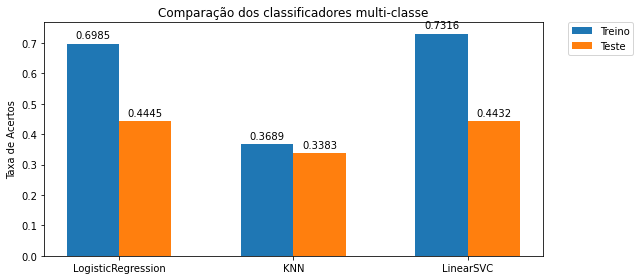

In [14]:
def plot_comparacao(treino, teste, titulo, labels):
    x = np.arange(len(labels))
    width = 0.3
    
    fig, ax = plt.subplots()
    fig.set_figwidth(9)
    rects1 = ax.bar(x - width/2, treino, width, label='Treino')
    rects2 = ax.bar(x + width/2, teste, width, label='Teste')
    
    ax.set_ylabel('Taxa de Acertos')
    ax.set_title(titulo)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height), xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), 
                        textcoords="offset points", ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()

labelsBi = ['LogisticRegression', 'KNN', 'LinearSVC']
labelsMulti = ['LogisticRegression', 'KNN', 'LinearSVC']
treinoBi = np.round([0.9583571428571429, 0.8074285714285714, 0.9527857142857142], 4)
testeBi = np.round([0.8990833333333333, 0.7796666666666666, 0.8994166666666666], 4)
treinoMulti = np.round([0.6984642857142858, 0.3688571428571429, 0.7316428571428572], 4)
testeMulti = np.round([0.4445, 0.3383333333333333, 0.44316666666666665 ], 4)

plot_comparacao(treinoBi, testeBi, 'Comparação dos classificadores binários', labelsBi)
plot_comparacao(treinoMulti, testeMulti, 'Comparação dos classificadores multi-classe', labelsMulti)

Pela análise dos resultados dos classificadores, verifica-se que para a classificação binária, o LinearSVC obteve os melhores valores. Para a classificação multi-classe, o Logistic Regression teve melhores valores que os outros classificadores.

Os melhores classificadores serão utilizados para as funções `binClassify` e `multiClassify`.

<a name="classify"></a> 
## 4.3 Funções `binClassify(X)` e `multiClassify(X)`
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

Dividimos os dados em treino e teste com proporções diferentes às usadas anteriormente, para maximizar o _score_, ainda que sem entrar em sobreaprendizagem. 

In [0]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.27, stratify=y_bool, random_state=0)

X1 = text2vector(X1)
X2 = text2vector(X2)

svc = LinearSVC(C=0.201).fit(X1,y1)
#pickle.dump(svc, open("classBinLinearSVC.p", 'wb'))

X1, X2, y1, y2 = train_test_split(X, y, test_size=0.28, stratify=y, random_state=0)

X1 = text2vector(X1)
X2 = text2vector(X2)
lg = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', C=1.03, tol=1e-3).fit(X1,y1)
#pickle.dump(lg, open("multiclassLogReg.p", 'wb'))

In [16]:
def binClassify(X):
    svc = pickle.load(open("classBinLinearSVC.p", 'rb'))
    ye = svc.predict(X)
    return ye

def multiClassify(X):
    lg = pickle.load(open("multiclassLogReg.p", 'rb'))
    ye = lg.predict(X)
    return ye

<a name="pca"></a> 
# 5. PCA
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

Utilizando os melhores classificadores para a classificação binária e multi-classe, testou-se vários valores de componentes principais para averiguar qual o valor ótimo.

Número de componentes:   1
% de acertos no treino:  0.5375
% de acertos no teste:   0.5348333333333334
Número de componentes:   5
% de acertos no treino:  0.6192142857142857
% de acertos no teste:   0.6181666666666666
Número de componentes:   10
% de acertos no treino:  0.7715
% de acertos no teste:   0.7701666666666667
Número de componentes:   15
% de acertos no treino:  0.8127142857142857
% de acertos no teste:   0.8149166666666666
Número de componentes:   25
% de acertos no treino:  0.8312142857142857
% de acertos no teste:   0.8311666666666667
Número de componentes:   50
% de acertos no treino:  0.8433928571428572
% de acertos no teste:   0.84075
Número de componentes:   75
% de acertos no treino:  0.848
% de acertos no teste:   0.8466666666666667
Número de componentes:   100
% de acertos no treino:  0.8516785714285714
% de acertos no teste:   0.85025
Número de componentes:   150
% de acertos no treino:  0.8630357142857142
% de acertos no teste:   0.8613333333333333
Número de compo

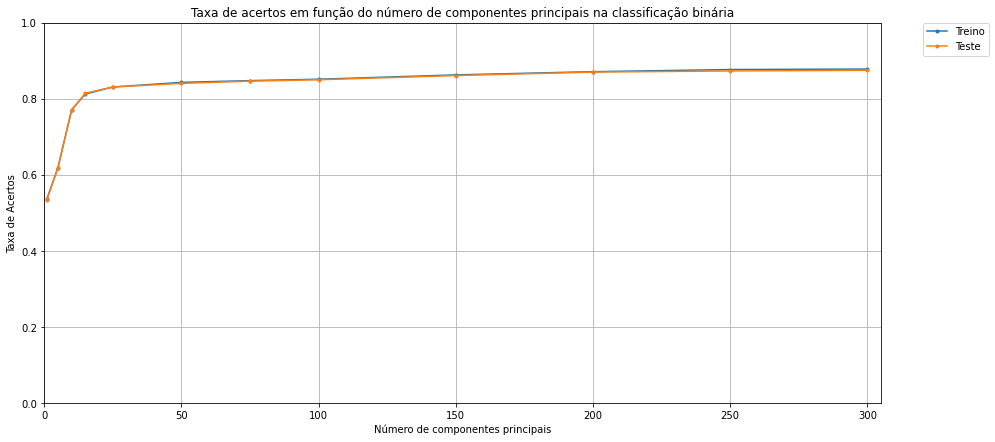

In [128]:
X1, X2, y1, y2 = train_test_split(X, y_bool, test_size=0.3, stratify=y_bool, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

components = [1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 300]
treino_score = []
teste_score = []

for component in components:
    svd = TruncatedSVD(n_components=component, random_state=0)
    svd.fit(X1)
    X1p = svd.transform(X1)
    X2p = svd.transform(X2)

    svc = LinearSVC(C=0.201).fit(X1p, y1)

    treino = svc.score(X1p, y1)
    teste = svc.score(X2p, y2)
    treino_score.append(treino)
    teste_score.append(teste)

    print('Número de componentes:  ', component)
    print('% de acertos no treino: ', treino)
    print('% de acertos no teste:  ', teste)

plt.figure(figsize=(15, 7))
plt.xlabel('Número de componentes principais')
plt.ylabel('Taxa de Acertos')
plt.title('Taxa de acertos em função do número de componentes principais na classificação binária')
plt.plot(components, treino_score, '.-', label='Treino')
plt.plot(components, teste_score, '.-', label='Teste')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.axis([0, 305, 0, 1])
plt.grid(); plt.show()

Número de componentes:   1
% de acertos no treino:  0.22267857142857142
% de acertos no teste:   0.21908333333333332
Número de componentes:   5
% de acertos no treino:  0.26917857142857143
% de acertos no teste:   0.26525
Número de componentes:   10
% de acertos no treino:  0.35764285714285715
% de acertos no teste:   0.36291666666666667
Número de componentes:   15
% de acertos no treino:  0.3924285714285714
% de acertos no teste:   0.39025
Número de componentes:   25
% de acertos no treino:  0.40210714285714283
% de acertos no teste:   0.4015
Número de componentes:   50
% de acertos no treino:  0.4124285714285714
% de acertos no teste:   0.40891666666666665
Número de componentes:   75
% de acertos no treino:  0.41917857142857146
% de acertos no teste:   0.41375
Número de componentes:   100
% de acertos no treino:  0.4238928571428571
% de acertos no teste:   0.41575
Número de componentes:   150
% de acertos no treino:  0.43425
% de acertos no teste:   0.42191666666666666
Número de comp

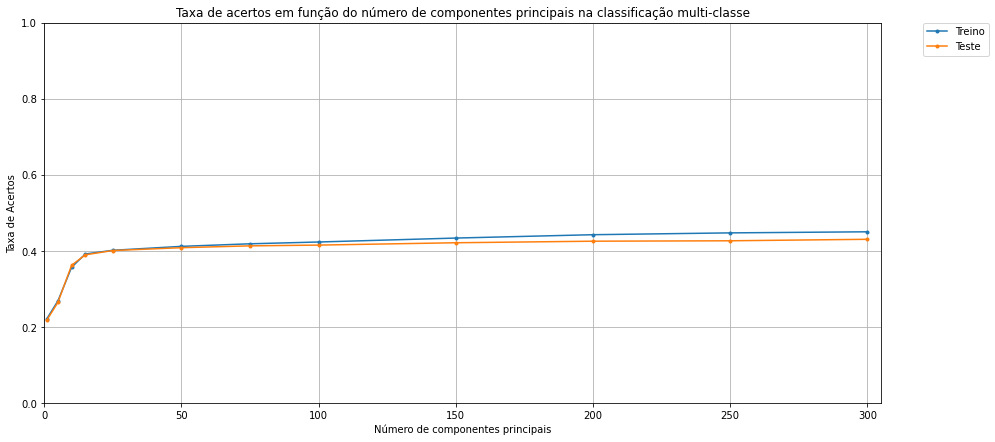

In [133]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)
X1 = text2vector(X1)
X2 = text2vector(X2)

components = [1, 5, 10, 15, 25, 50, 75, 100, 150, 200, 250, 300]
treino_score = []
teste_score = []

for component in components:
    svd = TruncatedSVD(n_components=component, random_state=0)
    svd.fit(X1)
    X1p = svd.transform(X1)
    X2p = svd.transform(X2)

    dl = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial', C=1.03, tol=1e-3)
    dl.fit(X1p, y1)

    treino = dl.score(X1p, y1)
    teste = dl.score(X2p, y2)
    treino_score.append(treino)
    teste_score.append(teste)

    print('Número de componentes:  ', component)
    print('% de acertos no treino: ', treino)
    print('% de acertos no teste:  ', teste)

plt.figure(figsize=(15, 7))
plt.xlabel('Número de componentes principais')
plt.ylabel('Taxa de Acertos')
plt.title('Taxa de acertos em função do número de componentes principais na classificação multi-classe')
plt.plot(components, treino_score, '.-', label='Treino')
plt.plot(components, teste_score, '.-', label='Teste')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.axis([0, 305, 0, 1])
plt.grid(); plt.show()

Para ambos os classificadores, o número de componentes principais ótimo é 200, pois a partir desse valor, os dados em treino e teste têm uma variação tão reduzida que se pode assumir que estes convergiram para um valor.

<a name="clustering"></a> 
# 6. Clustering
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

<a name="clusteringkmeans"></a> 
## 6.1 Clustering KMeans
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

Para evitar a presença de palavras muito utilizadas, filtrámos as _stop words_ do idioma inglês, através do parâmetro da função Tf-idf.

In [15]:
Docs = [doc.replace('<br />', ' ') for doc in X]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]

orig_n_clusters = 8
tfidf = TfidfVectorizer(stop_words='english').fit(Docs)
X_doc = tfidf.transform(Docs)
for j in range(2, orig_n_clusters + 8):
    model = KMeans(n_clusters=j, n_init=1).fit(X_doc)
    print('Number of clusters -> ', j)
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = tfidf.get_feature_names()
    for i in range(j):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
    print('\n')

Number of clusters ->  2
Top terms per cluster:
Cluster 0:
 movie
 bad
 just
 like
 movies
 good
 really
 don
 watch
 time
Cluster 1:
 film
 movie
 like
 just
 good
 story
 time
 great
 really
 films


Number of clusters ->  3
Top terms per cluster:
Cluster 0:
 film
 films
 like
 just
 good
 really
 movie
 story
 time
 great
Cluster 1:
 movie
 bad
 just
 movies
 like
 good
 really
 don
 watch
 time
Cluster 2:
 movie
 film
 like
 just
 story
 good
 time
 great
 really
 people


Number of clusters ->  4
Top terms per cluster:
Cluster 0:
 bad
 movie
 just
 acting
 like
 movies
 good
 really
 don
 film
Cluster 1:
 movie
 film
 like
 just
 good
 story
 time
 great
 really
 series
Cluster 2:
 film
 films
 like
 good
 just
 story
 really
 movie
 great
 time
Cluster 3:
 movie
 good
 like
 movies
 just
 really
 great
 watch
 don
 story


Number of clusters ->  5
Top terms per cluster:
Cluster 0:
 film
 movie
 story
 great
 good
 time
 like
 man
 life
 best
Cluster 1:
 just
 like
 movie
 really


In [5]:
Docs = [doc.replace('<br />', ' ') for doc in X]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]

orig_n_clusters = 8
tfidf = TfidfVectorizer(stop_words='english').fit(Docs)
X_doc = tfidf.transform(Docs)
j = 23
model = KMeans(n_clusters=j, n_init=1).fit(X_doc)
print('Number of clusters -> ', j)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(j):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Number of clusters ->  23
Top terms per cluster:
Cluster 0:
 film
 like
 movie
 time
 just
 people
 story
 good
 films
 way
Cluster 1:
 movie
 good
 like
 story
 movies
 time
 just
 really
 character
 film
Cluster 2:
 war
 film
 movie
 world
 soldiers
 story
 time
 vietnam
 german
 just
Cluster 3:
 great
 movie
 film
 good
 story
 really
 just
 movies
 best
 like
Cluster 4:
 love
 movie
 story
 film
 like
 just
 movies
 time
 really
 great
Cluster 5:
 movie
 movies
 good
 like
 watch
 just
 really
 don
 time
 seen
Cluster 6:
 book
 movie
 read
 novel
 film
 story
 like
 good
 characters
 books
Cluster 7:
 comedy
 movie
 film
 funny
 good
 romantic
 like
 just
 laugh
 time
Cluster 8:
 horror
 movie
 film
 good
 movies
 gore
 films
 like
 just
 really
Cluster 9:
 series
 episode
 episodes
 season
 like
 just
 good
 tv
 characters
 great
Cluster 10:
 game
 games
 graphics
 play
 movie
 video
 mario
 just
 like
 good
Cluster 11:
 life
 movie
 film
 real
 story
 people
 family
 like
 love
 

In [15]:
critics = ['I love every single Jackie Chan movie.', 'Vietnam war movie with so many deaths, the soldiers looked so realistic.', 'Such a realistic sci-fi.', 'Comedy movies like this are always terrible, hate them.']
critics_t = tfidf.transform(critics)
pred = model.predict(critics_t)
for review, cluster in zip(critics, pred):
    print('%r => %s' % (review, cluster))

'I love every single Jackie Chan movie.' => 22
'Vietnam war movie with so many deaths, the soldiers looked so realistic.' => 2
'Such a realistic sci-fi.' => 15
'Comedy movies like this are always terrible, hate them.' => 7


In [59]:
Docs = [doc.replace('<br />', ' ') for doc in X]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs]

orig_n_clusters = 8
tfidf = TfidfVectorizer(stop_words='english').fit(Docs)
X_doc = tfidf.transform(Docs)
j = 25
model = KMeans(n_clusters=j, n_init=1).fit(X_doc)
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(j):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 family
 father
 movie
 mother
 film
 son
 children
 daughter
 good
 story
Cluster 1:
 jane
 tarzan
 austen
 eyre
 rochester
 emma
 version
 novel
 dalton
 film
Cluster 2:
 funny
 movie
 comedy
 just
 jokes
 like
 good
 really
 film
 laugh
Cluster 3:
 zombie
 zombies
 movie
 film
 dead
 just
 like
 gore
 horror
 bad
Cluster 4:
 series
 episode
 episodes
 season
 tv
 like
 just
 good
 great
 characters
Cluster 5:
 film
 films
 story
 like
 time
 great
 just
 good
 movie
 characters
Cluster 6:
 movie
 movies
 good
 like
 great
 just
 time
 seen
 story
 film
Cluster 7:
 christmas
 santa
 movie
 scrooge
 claus
 film
 grinch
 family
 story
 holiday
Cluster 8:
 eddie
 murphy
 movie
 funny
 niro
 delirious
 comedy
 stand
 film
 showtime
Cluster 9:
 dvd
 movie
 film
 version
 great
 time
 release
 like
 copy
 vhs
Cluster 10:
 game
 games
 graphics
 play
 movie
 video
 mario
 just
 like
 levels
Cluster 11:
 life
 story
 love
 movie
 film
 real
 man
 people
 lik

In [60]:
#cluster 22
#ver comentários acerca de steven seagal e filmes de ação
X = D['data']
Docs = [doc.replace('<br />', ' ') for doc in X]
matching = [s for s in Docs if terms[order_centroids[22, 3]] in s and terms[order_centroids[22, 0]] in s]
for i in matching[:10]:
    print(i)
    print()

What was Steven Seagal thinking? I mean firstly I love Seagal. I love all his movies up to the mid 2000s. His early stuff is some of the best in the genre. This however does not live up to its excellent name. Attack Force (with protagonist Marshall Lawson {Seagal}) would be expected to be a mindless action movie with Seagal in typical one-liner ass kicking form. However, what we get is a crime mystery, bordering on a political thriller with little or no action. Seagal is always in shadows because of his weight. I could not follow this story. There's people who mutate to superhumans when they take a drug. What happened in this movie. The dubbing of Seagal is a disgrace, a shambles and a shame. Why dub the man? The story is terrible. This got a 2/10 from me because of the scene where Seagal asks for backup despite having an army with him, and an hilarious fight scene where seagal swings his hands like a girl facing the camera! "Revenge is a two way street" seagal says in this movie...wel

In [62]:
#cluster 19
#ver comentários acerca de disney e animação
matching = [s for s in Docs if terms[order_centroids[19, 0]] in s and terms[order_centroids[19, 1]] in s]
for i in matching[:10]:
    print(i)
    print()

No day passes without a new released computer animated movie, so we now really have chances to see more than some nice effects. After watching Ice Age I felt that's it was not that big impact on me than some other films of this genre.  But it's because I am a Big Guy now, and I am pretty sure that this is a very enjoyable movie for children (maybe up to 14). The story is quite simple, and the "actors" are funny in a cute way, without any crude or complex humour. Even the "evil" is lovely, fluffy big cat with those funny teeth. And the story has a happy end, which was a small disappointment for me (knowing that most of the main characters are doomed to extinction in a sad way) but a great thing for children. And apart from some fights nobody dies (not even when he gets stomped on by a mammoth, several times), which made a cartoony feeling.  The computer animation part is nice but nothing special, apart from some really nice cartoony feeling scenes, when you feel like walking in a nice p

<a name="clusteringhierarquico"></a> 
## 6.2 Clustering Hierárquico
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

In [20]:
X1, X2, y1, y2 = train_test_split(X, y, stratify=y, test_size=0.06)
Docs1 = [doc.replace('<br />', ' ') for doc in X1]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs1 = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs1]
Docs2 = [doc.replace('<br />', ' ') for doc in X2]
# de a-z, A-Z e caracteres especiais latinos unicode
Docs2 = [re.sub(r'[^a-zA-Z\u00C0-\u00FF]+', ' ', doc) for doc in Docs2]


tfidf = TfidfVectorizer(min_df=2, max_df=.5,stop_words='english').fit(Docs1)

X1 = tfidf.transform(Docs1)
X_tr = tfidf.transform(Docs2)

svd = TruncatedSVD(n_components=200, random_state=0)
svd.fit(X1)
Xp = svd.transform(X_tr)

from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


agg = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(Xp)

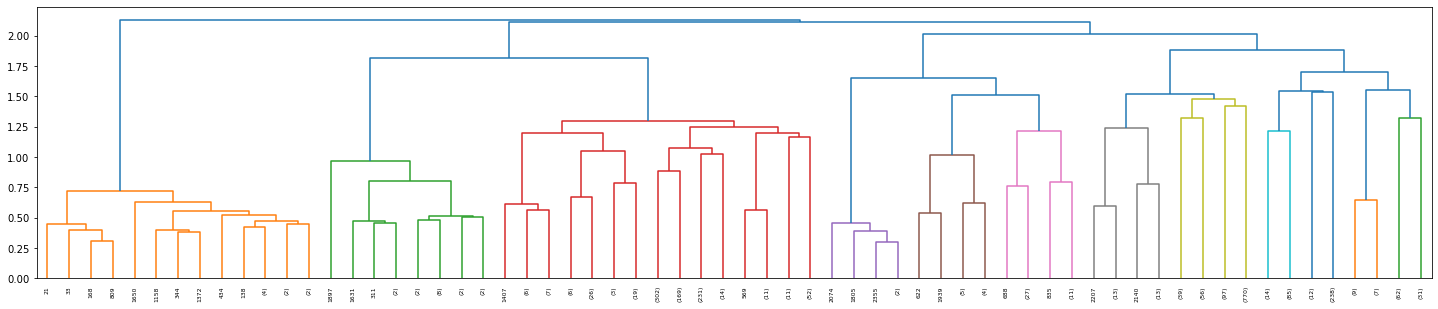

In [32]:
plt.figure(figsize=(25,5))
plot_dendrogram(agg, truncate_mode='level', p=6)

No dendrograma (figura acima), estão os últimos 4 níveis do agrupamento realizado pelo algoritmo de _AggregativeClustering_. Os _tokens_ foram juntos sequencialmente, pelo algoritmo de ligação de _Ward_, de forma a formarem-se novos _clusters_ que minimizem a distância euclidiana entre eles, cada vez maiores, até à convergência num só _cluster_ final. Assim, é possível ver como as críticas se aproximam, pela semelhança dos tópicos, nos _clusters_ mais abaixo.

In [37]:
#laranja(3 e 4) - videojogos
print(Docs2[168])
print(Docs2[809])
print(Docs2[21])
print(Docs2[33])
print()
#2º laranja(7,8 e 6) - jogos
print(Docs2[344])
print(Docs2[1372])
print(Docs2[1158])
print()
#roxo - batman
print(Docs2[2074])
print(Docs2[1805])
print()
#verde - filmes baseados em livros
print(Docs2[1897])
print(Docs2[1631])
print()
#cinza - filmes infantis
print(Docs2[2207])
print(Docs2[2140])

I play this game exactly after I watch the trailer in old magazine advertise CD The is very interesting and dark atmospheric missing in nowadays games movies The game is set somewhere in the middle of the in the spooky mysterious mansion You play as Adam Randell and your quest is to free the soul of your death trapped father The look of the game is doom like but very different type of game A lot of a action various puzzles quests mazes and many more interesting locations and characters are presented in this old classic game The game will run only on Windows and there is no patch for Windows XP 
David Cronenberg movies are easily identifiable or at least elements within the movie stand out as his trademarks Fetishism the blurring between the organic and inorganic squishy throbbing things that shouldn t be squishy and throbbing eXistenZ is classic Cronenberg Briefly it s about a future generation of computer games but instead of a video monitor visuals are supplied by your mind The game 

<a name="conclusao"></a> 
# 7. Conclusão
<a style="text-align: right">[Voltar ao Índice](#indice)</a>

Com este trabalho, pôde-se por em prática os conhecimentos obtidos durante a disciplina de Aprendizagem Automática, relativamente à limpeza e ao processamento de dados de texto, podendo formar vocabulários reduzidos sem que se deteriore significativamente o resultado da classificação, bem como ao uso de diferentes classificadores para categorizar objetos, ideias, textos, etc, agrupando-os por classe, de forma binária e multi-classe. 

Conseguimos obter melhores resultados na classificação binária do que na multi-classe, pela dificuldade de definir corretamente o valor exato numérico da classificação da crítica com base nas palavras apreciativas utilizadas. É naturalmente mais fácil caracterizá-las como negativas ou positivas. 

O objetivo foi ter as melhores taxas de acerto (_accuracy_), daí ser necessário encontrar os melhores parâmetros para cada classificador, simultaneamente evitando a sobreaprendizagem, embora noutros contextos de problemas as métricas mais apropriadas possam ser diferentes, que minimizem os falsos negativos ou os falsos positivos.

Verificaram-se também metodologias de pré-processamento de dados, para reduzir a sua dimensionalidade, ou até o uso de classificadores não supervisionados, que não conhecem _a priori_ a verdadeira classe dos dados, para as agrupar por tópico abordado.

Conclui-se assim que os objetivos do trabalho foram cumpridos com sucesso, tendo-se demostrado diversos conhecimentos e princípios da área de _machine learning_ aplicados a dados de texto.